# Opal Masterclass mit maschinellem Lernen

Lade Funktionen und alles was sonst noch nötig ist...

In [1]:
from opal_mc_ml_helpers import *

Bilder schon vorhanden


Lade die Bilder der Events in eine Liste mit dem Namen bilddaten

In [3]:
bilddaten = lade_bilder()

609 Bilder geladen


Mit `bilddaten[x]` kann auf das `x-1`-ste Bild zugegriffen werden. Die Methode `.zeige_bild()` gibt das Bild grafisch aus.

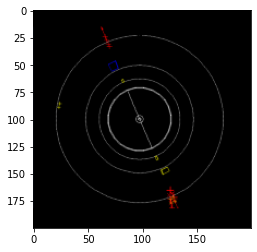

Name: z5293_15219.png 	 Kategorie: m


In [4]:
bilddaten[53].zeige_bild(zeige_kategorie=True)

Mit `zeige_uebersicht()` erhält man eine Übersicht über die Verteilung der Kategorien. Der erste Parameter gibt an, wie die Spalte beschriftet sein soll. Danach folgen ein oder mehrere Listen mit Bildateien.

In [5]:
zeige_uebersicht(["Roh"], bilddaten)

	Roh			Theorie			
#Evt:	609			

q:	529	86.86%		87.38%
e:	24	3.94%		4.20%
m:	27	4.43%		4.21%
t:	29	4.76%		4.21%


Nun werden die Bildateien in zwei Datensätze aufgeteilt. `tv` ist kurz für Training+Validierung. 

In [26]:
bilddaten_tv, bilddaten_test = trenne_bilddaten_zufaellig(bilddaten, anteil_erster_block=0.3)

Im nächsten Schritt werden die `tv`-Daten vervielfältigt, damit das Training einfacher wird. Alle Bilder werden verfünffacht. Dafür werden jeweils vier Kopien des Bildes mit zufälligen Rotationen erstellt. Die Hälfte der Bilder wird zusätzlich zufällig gespiegelt. 
Um das Training der Leptonenzerfälle zu verbessern werden die Daten zu diesen Events zusätzlich noch verzwölffacht.

In [27]:
faktor_alle = 5
faktor_leptonen = 12
bilddaten_tv_vermehrt = vervielfaeltige_daten(bilddaten_tv, [faktor_alle, faktor_alle*faktor_leptonen, faktor_alle*faktor_leptonen, faktor_alle*faktor_leptonen])

Nun werden die `tv`-Daten in Training (`t`) und Validierung (`v`) unterteilt.

Abschließend wird erneut eine Übersicht ausgegeben.

In [28]:
bilddaten_training, bilddaten_validierung = trenne_bilddaten_zufaellig(bilddaten_tv_vermehrt, anteil_erster_block=0.66)

zeige_uebersicht(["Roh", "TV", "TV verm", "Train", "Vali", "Test"], bilddaten, bilddaten_tv, bilddaten_tv_vermehrt, bilddaten_training, bilddaten_validierung, bilddaten_test)

	Roh			TV			TV verm			Train			Vali			Test			Theorie			
#Evt:	609			182			2395			1580			815			427			

q:	529	86.86%		155	85.16%		775	32.36%		487	30.82%		288	35.34%		374	87.59%		87.38%
e:	24	3.94%		8	4.40%		480	20.04%		322	20.38%		158	19.39%		16	3.75%		4.20%
m:	27	4.43%		7	3.85%		420	17.54%		290	18.35%		130	15.95%		20	4.68%		4.21%
t:	29	4.76%		12	6.59%		720	30.06%		481	30.44%		239	29.33%		17	3.98%		4.21%


Die Trainingsdaten sind jetzt passend vorbereitet. Im nächsten Block wird ein Modell zum Lernen erstellt. Die Struktur wird einmal ausgegeben. In den letzten beiden Zeilen werden die Trainings- und Validierungsdaten geladen.

In [29]:
modell = Modell()
modell.lade_modellstruktur()
modell.zeige_modelluebersicht()
modell.lade_trainingsdaten(bilddaten_training)
modell.lade_validierungsdaten(bilddaten_validierung)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)             

Mit `trainiere()` wird das Training des Modells gestartet. `anzahl_epochen` gibt an, wie oft über alle Trainings- und Validierungsdaten gelaufen wird. Bei diesen Daten sind häufig Werte zwischen 3 und 6 sinnvoll.

In [30]:
modell.trainiere(anzahl_epochen=4)

Starte Training...
Epoch 1/3
50/50 [==============================] - 17s 337ms/step - loss: 1.3456 - accuracy: 0.3284 - val_loss: 0.9775 - val_accuracy: 0.6540
Epoch 2/3
50/50 [==============================] - 16s 328ms/step - loss: 0.7421 - accuracy: 0.6819 - val_loss: 0.2735 - val_accuracy: 0.9374
Epoch 3/3
50/50 [==============================] - 16s 329ms/step - loss: 0.2443 - accuracy: 0.9113 - val_loss: 0.1652 - val_accuracy: 0.9485
Training abgeschlossen, hat 0:00:50.389084 gedauert


Die Lernkurve zeigt an, wie die Treffergenauigkeit sich im Laufe des Trainings verändert. Dabei wird die Treffergenauigkeit in Trainingsdaten und Validierungsdaten getrennt aufgetragen.

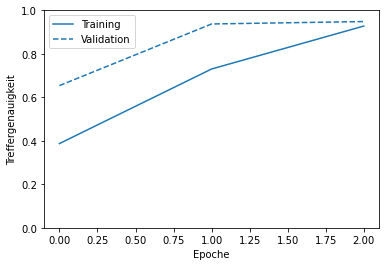

In [31]:
modell.zeige_lernkurve()

Mit dem trainierten Modell können wir nun die Kategorien der Testdaten vorhersagen. Dabei wird die schon zugewiesene Kategorie der Testdaten ignoriert. Die Confusion Matrix ist ein Indikator dafür, wie gut die Vorhersage mit dem Modell funktioniert. Ein perfektes Modell hätte nur Einträge auf der Diagonalen: Jede Kategorie wird vom Modell so erkannt, wie sie vorher schon dem Bild zugeordnet war. Tatsächlich treten häufig einige falsche Vorhersagen auf. 

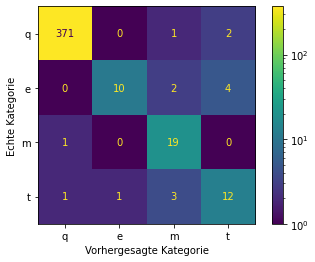

In [33]:
bilddaten_vorhersage = modell.erstelle_vorhersage(bilddaten_test)
zeige_confusion_matrix(bilddaten_test, bilddaten_vorhersage)

Hier wird die Übersicht über die Verzweigungsverhältnisse noch um eine Spalte mit den vorhergesagten Daten erweitert.

In [34]:
zeige_uebersicht(["Roh", "TV", "TV verm", "Train", "Vali", "Test", "Vorh"], bilddaten, bilddaten_tv, bilddaten_tv_vermehrt, bilddaten_training, bilddaten_validierung, bilddaten_test, bilddaten_vorhersage)

	Roh			TV			TV verm			Train			Vali			Test			Vorh			Theorie			
#Evt:	609			182			2395			1580			815			427			427			

q:	529	86.86%		155	85.16%		775	32.36%		487	30.82%		288	35.34%		374	87.59%		373	87.35%		87.38%
e:	24	3.94%		8	4.40%		480	20.04%		322	20.38%		158	19.39%		16	3.75%		11	2.58%		4.20%
m:	27	4.43%		7	3.85%		420	17.54%		290	18.35%		130	15.95%		20	4.68%		25	5.85%		4.21%
t:	29	4.76%		12	6.59%		720	30.06%		481	30.44%		239	29.33%		17	3.98%		18	4.22%		4.21%


Man kann sich nun noch anschauen, welche Bilder falsch vorhergesagt wurden. Gelegentlich ist eine Einteilung auch für Menschen nicht eindeutig möglich.

Insgesamt 15 falsche Vorhersagen
zeige erste 5 ...



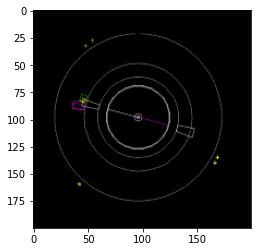

Name: z5297_5768.png
wurde als m erkannt, ist aber q 



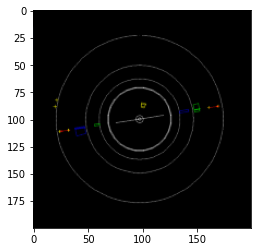

Name: z5293_19522.png
wurde als q erkannt, ist aber m 



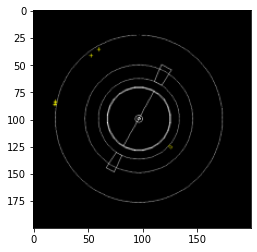

Name: e5293_14404.png
wurde als t erkannt, ist aber e 



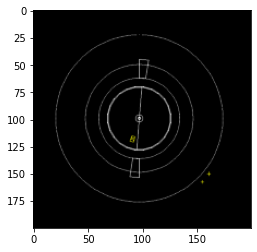

Name: e5293_14643.png
wurde als t erkannt, ist aber e 



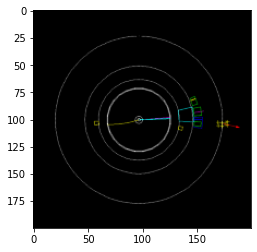

Name: z5293_6387.png
wurde als q erkannt, ist aber t 



In [35]:
zeige_falsche_vorhersagen(bilddaten_test, bilddaten_vorhersage, anzahl=5)